In [1]:
# Analysis pipeline for pupillometry waveforms.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy

from PyGazeAnalyser.pygazeanalyser.edfreader import read_edf

# Select pre-pilot, pilot, real experiment, or 

22201: 199826
22202: 1082692
22203: 198763
22204: 729962

# Important Functions

In [2]:
def blink_buffer_loop(array_,buffer=15):
    arr_ = np.copy(array_)
    for i in range(arr_.shape[0]):
        blink_times_=[]
        for j in range(arr_.shape[1]):
            if arr_[i,j]==0:
                blink_times_.append(j)
        for j in blink_times_:
            arr_[i,j-buffer:j+buffer]=0
    return arr_

def find_theta(x_,y_,radius_):
    theta_ = np.arccos(y_/radius_)
    for i in range(len(x_)):
        if x_[i]<0:
            theta_[i]=-theta_[i]+2*np.pi
    return theta_

def find_report(x_,y_,radius_,trev_,tevent_):
    theta_ = find_theta(x_,y_,radius_)
    closest_times=[]
    before_times=[]
    for i in range(len(theta_)):
        time_to_theta = trev_*theta_[i]/(2*np.pi)
        possible_times = np.array([time_to_theta+trev_*k for k in range(int(np.ceil(tevent_[i]/trev_+2)))])
        
        # append closest_time with the potential report time closest to the event time. Used for w, m, and s trials.
        closest_times.append(possible_times[np.argmin(np.absolute(possible_times-tevent_[i]))])
        
        # append before_time with the possible time that happens immediately before the event. Used for i trials. 
        before_times.append(possible_times[int(np.floor(tevent_[i]/trev_))])
    return {'closest_times':closest_times,'before_times':before_times}
        

# Main Function (unfinished)

In [3]:
# This main function will read in the EDF files and do things. Will add things in from below.

def segment_pupil_data(sub_id_, time_start_, asc_filepath_, beh_filepath_, sampling_rate_, rev_time_,clock_radius_):
    edf_data_ = read_edf(asc_filepath_+sub_id_+'.asc',time_start)
    beh_data_ = pd.read_csv(beh_filepath_+sub_id_+'.csv')
    
    # Adding the specific time to 
    beh_data_[['t_closest','t_before']]=pd.DataFrame(find_report(beh_data_['x'].values,beh_data_['y'].values,clock_radius_,rev_time_,beh_data['event_time']))
    beh_data['tref']=0
    beh_data['tref']=beh_data['t_closest'].values-beh_data['event_time'].values
    mask = beh_data['block_type'].str.match('i')
    beh_data.loc[mask,'tref']=beh_data.loc[mask,'t_before'].values-beh_data.loc[mask,'event_time'].values

In [4]:
A=np.array([0,1,2,3])


In [5]:
np.floor(A/3)

array([0., 0., 0., 1.])

# Testing

### Read files in for selected participants

In [6]:
sub_ids = [['22201','199826'],['22202','1082692'],['22203','198763'],['22204','729962'],['22205','365396'],['22206','572903']]
subject_no =0

In [8]:
RATE = 500 # Sampling rate in Hz
trev = 2.5
clock_radius = 2.5
FLASH = False

if FLASH:
    asc_path = 'D:\\EyeDecide\\ASC\\' 
    beh_path = 'D:\\EyeDecide\\Behavioral\\'
    short_path = 'D:\\EyeDecide\\Shortform\\'
    long_path = 'D:\\EyeDecide\\Longform\\'
else:
    asc_path = 'E:\\Admin\\Research\\Eye Decide\\ASC\\' 
    beh_path = 'E:\\Admin\\Research\\Eye Decide\\Behavioral\\'
    short_path = 'E:\\Admin\\Research\\Eye Decide\\Shortform\\'
    long_path = 'E:\\Admin\\Research\\Eye Decide\\Longform\\'


edf_data = read_edf(asc_path+sub_ids[subject_no][0]+'.asc',sub_ids[subject_no][1])
beh_data = pd.read_csv(beh_path+sub_ids[subject_no][0]+'.csv')

### Get the reported times and add them to the beh_data dataframe

In [9]:
# Use our self-defined function find_report
beh_data[['t_closest','t_before']]=pd.DataFrame(find_report(beh_data['x'].values,beh_data['y'].values,2.5,2.5,beh_data['event_time']))

Change reported times to referenced times - i.e. how far before/after the event takes place (in seconds)

In [10]:
beh_data['tref']=0
beh_data['tref']=beh_data['t_closest'].values-beh_data['event_time'].values
mask = beh_data['block_type'].str.match('i')
beh_data.loc[mask,'tref']=beh_data.loc[mask,'t_before'].values-beh_data.loc[mask,'event_time'].values

In [11]:
beh_data[beh_data['block_type'].str.match('i')].describe()

,event_time,block_id,trial_number,x,y,Unnamed: 8,t_closest,t_before,tref
count,55.000000,55.000000,55.000000,55.000000,55.000000,0.0,55.000000,55.000000,55.000000
mean,9.998877,2.181818,7.545455,0.629176,-0.015823,NaN,10.025013,9.570468,-0.428409
std,2.267694,0.840875,4.246210,1.765697,1.686596,NaN,2.316869,2.498974,1.063473
min,6.958326,1.000000,1.000000,-2.478836,-2.493493,NaN,6.221287,5.163557,-2.166845
25%,8.569455,1.000000,4.000000,-1.197742,-1.495405,NaN,8.293226,7.989299,-1.252179
50%,9.680598,2.000000,7.000000,1.118034,-0.145104,NaN,9.658438,9.118959,-0.573104
75%,10.934032,3.000000,11.000000,2.061675,1.541164,NaN,10.908495,10.908495,0.550726
max,16.527817,3.000000,15.000000,2.497031,2.481615,NaN,16.057232,16.057232,1.531182


### Goal: 
1. Create a dataframe with the times and event names as two columns 
2. Append this dataframe with columns from the behavioral data. 
3. Use this dataframe as a basis for segmenting the data.

In [12]:
temp_event_markers=[]
for i in range(len(edf_data)):
    if edf_data[i]['events']['msg']:
        temp_event_markers.append(edf_data[i]['events']['msg'])
event_markers = [item for sublist in temp_event_markers for item in sublist]

In [13]:
df = pd.DataFrame(event_markers,columns=['EventTime','Label'])
df['EventTime'] = df['EventTime'] - int(sub_ids[subject_no][1])


Get rid of all the events that do not contain 'EVENT-TIME'

In [14]:
df = df[df['Label'].str.contains('EVENT-TIME')].reset_index()
events=pd.concat([df,beh_data],axis=1)

In [15]:
temp_pupil_size = []
for i in range(len(edf_data)):
    print('Mismatch at: '+str(i)) if len(edf_data[i]['time'])!=len(edf_data[i]['size']) else False
    temp_pupil_size.append(np.vstack(np.array([edf_data[i]['time'],edf_data[i]['size']])))
pupil_size = np.hstack(temp_pupil_size)

In [16]:
mask = ~events['is_practice']
events = events[mask].reset_index()
del events['level_0']
del events['index']
del events['Unnamed: 8']

print(events.shape)
events.head()


(210, 13)


,EventTime,Label,event_time,block_type,block_id,is_practice,is_report,trial_number,x,y,t_closest,t_before,tref
0,166804,b'EVENT-TIME RECORDED - KEYPRESSED.'\n,5.770886,no_report,1,False,False,1,0.0,0.0,5.625,5.625,-0.145886
1,178888,b'EVENT-TIME RECORDED - KEYPRESSED.'\n,7.715298,no_report,1,False,False,2,0.0,0.0,8.125,8.125,0.409702
2,194931,b'EVENT-TIME RECORDED - KEYPRESSED.'\n,8.250010,no_report,1,False,False,3,0.0,0.0,8.125,8.125,-0.125010
3,210085,b'EVENT-TIME RECORDED - KEYPRESSED.'\n,8.569512,no_report,1,False,False,4,0.0,0.0,8.125,8.125,-0.444512
4,226246,b'EVENT-TIME RECORDED - KEYPRESSED.'\n,7.979127,no_report,1,False,False,5,0.0,0.0,8.125,8.125,0.145873


In [17]:
events[events['block_type'].str.match('i')].head()

,EventTime,Label,event_time,block_type,block_id,is_practice,is_report,trial_number,x,y,t_closest,t_before,tref
75,2696610,b'EVENT-TIME RECORDED - KEYPRESSED.'\n,9.083356,i,1,False,True,1,0.263234,-2.486103,8.708027,8.708027,-0.375329
76,2713604,b'EVENT-TIME RECORDED - KEYPRESSED.'\n,9.916668,i,1,False,True,2,2.458205,-0.455223,10.697857,8.197857,-1.718811
77,2730695,b'EVENT-TIME RECORDED - KEYPRESSED.'\n,9.451366,i,1,False,True,3,-2.000000,-1.500000,9.118959,9.118959,-0.332407
78,2746182,b'EVENT-TIME RECORDED - KEYPRESSED.'\n,9.805616,i,1,False,True,4,0.854358,2.349484,10.138772,7.638772,-2.166845
79,2762517,b'EVENT-TIME RECORDED - KEYPRESSED.'\n,7.402851,i,1,False,True,5,2.392051,-0.726699,8.242352,5.742352,-1.660499


In [55]:
# events.loc[events['block_type'].str.match('i'),'EventTime']+np.ceil(events.loc[events['block_type'].str.match('i'),'tref']*1000)

In [24]:
scipy.stats.describe(events.loc[events['block_type'].str.match('i'),'tref'].values)

DescribeResult(nobs=45, minmax=(-2.166844605481076, 1.5311822096485743), mean=-0.4347040695888656, variance=1.1835939654791032, skewness=0.42595656351650285, kurtosis=-1.0951439030361731)

In [25]:
# print(pupil_size[:,0:19])
# print(pupil_size[:,-20:-1])

In [26]:
# no_practice.tail()

In [27]:
# DATA SEGMENTATION
# Select how many seconds before/after to go. The selection here should be fairly large compared to the final interval we want.
start=3
stop=3
pupil_size_to_df = []

# THIS ADJUSTS EVENT TIMES FOR I TIME ACCORDING TO SELF REPORT
is_I_fixed = True

if is_I_fixed:
    mask = events['block_type'].str.match('i')
    events.loc[mask,'EventTime'] = events.loc[mask,'EventTime']+np.ceil(events.loc[mask,'tref']*1000)

for i in range(events.shape[0]):
    align_time = events.loc[i,'EventTime']
    if align_time%2==0:

        align_idx = np.where(pupil_size[0,:]==align_time)[0][0]
    else:

        align_idx = np.where(pupil_size[0,:]==align_time-1)[0][0]
    epoch_begin = align_idx-start*RATE
    epoch_end = align_idx+stop*RATE
    trial_pupil = pupil_size[1,epoch_begin:epoch_end]
    pupil_size_to_df.append(trial_pupil)
    
    
events['PupilSize']=pupil_size_to_df

In [28]:
events.head()

,EventTime,Label,event_time,block_type,block_id,is_practice,is_report,trial_number,x,y,t_closest,t_before,tref,PupilSize
0,166804.0,b'EVENT-TIME RECORDED - KEYPRESSED.'\n,5.770886,no_report,1,False,False,1,0.0,0.0,5.625,5.625,-0.145886,"[515.0, 515.0, 515.0, 515.0, 514.0, 514.0, 515..."
1,178888.0,b'EVENT-TIME RECORDED - KEYPRESSED.'\n,7.715298,no_report,1,False,False,2,0.0,0.0,8.125,8.125,0.409702,"[422.0, 423.0, 423.0, 423.0, 422.0, 422.0, 421..."
2,194931.0,b'EVENT-TIME RECORDED - KEYPRESSED.'\n,8.250010,no_report,1,False,False,3,0.0,0.0,8.125,8.125,-0.125010,"[434.0, 435.0, 435.0, 435.0, 435.0, 435.0, 436..."
3,210085.0,b'EVENT-TIME RECORDED - KEYPRESSED.'\n,8.569512,no_report,1,False,False,4,0.0,0.0,8.125,8.125,-0.444512,"[423.0, 423.0, 423.0, 423.0, 423.0, 422.0, 422..."
4,226246.0,b'EVENT-TIME RECORDED - KEYPRESSED.'\n,7.979127,no_report,1,False,False,5,0.0,0.0,8.125,8.125,0.145873,"[443.0, 442.0, 442.0, 443.0, 443.0, 444.0, 444..."


In [30]:
nr_trials = np.array(events.loc[events['block_type'].str.match('no_report'),'PupilSize'].values.tolist())
w_trials = np.array(events.loc[events['block_type'].str.match('w'),'PupilSize'].values.tolist())
i_trials = np.array(events.loc[events['block_type'].str.match('i'),'PupilSize'].values.tolist())
m_trials = np.array(events.loc[events['block_type'].str.match('m'),'PupilSize'].values.tolist())
s_trials = np.array(events.loc[events['block_type'].str.match('s'),'PupilSize'].values.tolist())

In [31]:
# BUFFERING and INTERPOLATION
blink_buffer = 20
interp_method = 'spline'
order=3

# Use below for interpolation. Creates time axis in milliseconds.
if interp_method in ['polynomial','spline']:
    nr_trials_buff = blink_buffer_loop(nr_trials,buffer=blink_buffer)
    nr_trials_buff[nr_trials_buff==0]=np.nan
    nr_trials_interp = pd.DataFrame(nr_trials_buff).interpolate(method=interp_method,order=3,axis=1,limit_direction='forward')
    s_trials_buff = blink_buffer_loop(s_trials,buffer=blink_buffer)
    s_trials_buff[s_trials_buff==0]=np.nan
    s_trials_interp = pd.DataFrame(s_trials_buff).interpolate(method=interp_method,order=3,axis=1,limit_direction='forward')
    w_trials_buff = blink_buffer_loop(w_trials,buffer=blink_buffer)
    w_trials_buff[w_trials_buff==0]=np.nan
    w_trials_interp = pd.DataFrame(w_trials_buff).interpolate(method=interp_method,order=3,axis=1,limit_direction='forward')
    i_trials_buff = blink_buffer_loop(i_trials,buffer=blink_buffer)
    i_trials_buff[i_trials_buff==0]=np.nan
    i_trials_interp = pd.DataFrame(i_trials_buff).interpolate(method=interp_method,order=3,axis=1,limit_direction='forward')
    m_trials_buff = blink_buffer_loop(m_trials,buffer=blink_buffer)
    m_trials_buff[m_trials_buff==0]=np.nan
    m_trials_interp = pd.DataFrame(m_trials_buff).interpolate(method=interp_method,order=3,axis=1,limit_direction='forward')
else:
    nr_trials_buff = blink_buffer_loop(nr_trials,buffer=blink_buffer)
    nr_trials_buff[nr_trials_buff==0]=np.nan
    nr_trials_interp = pd.DataFrame(nr_trials_buff).interpolate(method=interp_method,axis=1,limit_direction='forward')
    s_trials_buff = blink_buffer_loop(s_trials,buffer=blink_buffer)
    s_trials_buff[s_trials_buff==0]=np.nan
    s_trials_interp = pd.DataFrame(s_trials_buff).interpolate(method=interp_method,axis=1,limit_direction='forward')
    w_trials_buff = blink_buffer_loop(w_trials,buffer=blink_buffer)
    w_trials_buff[w_trials_buff==0]=np.nan
    w_trials_interp = pd.DataFrame(w_trials_buff).interpolate(method=interp_method,axis=1,limit_direction='forward')
    i_trials_buff = blink_buffer_loop(i_trials,buffer=blink_buffer)
    i_trials_buff[i_trials_buff==0]=np.nan
    i_trials_interp = pd.DataFrame(i_trials_buff).interpolate(method=interp_method,axis=1,limit_direction='forward')
    m_trials_buff = blink_buffer_loop(m_trials,buffer=blink_buffer)
    m_trials_buff[m_trials_buff==0]=np.nan
    m_trials_interp = pd.DataFrame(m_trials_buff).interpolate(method=interp_method,axis=1,limit_direction='forward')

In [32]:
# How much to chop from beginning and end of 
chop_amount = 250
XX = [i for i in np.arange((-start+chop_amount/RATE),(start-chop_amount/RATE),1/RATE)]

nr_trials = pd.DataFrame(nr_trials_interp.values[:,chop_amount:-chop_amount].T)
nr_trials.insert(0,'CondType','No Report')
s_trials = pd.DataFrame(s_trials_interp.values[:,chop_amount:-chop_amount].T)
s_trials.insert(0,'CondType','S-Time')
w_trials = pd.DataFrame(w_trials_interp.values[:,chop_amount:-chop_amount].T)
w_trials.insert(0,'CondType','W-Time')
i_trials = pd.DataFrame(i_trials_interp.values[:,chop_amount:-chop_amount].T)
i_trials.insert(0,'CondType','I-Time')
m_trials = pd.DataFrame(m_trials_interp.values[:,chop_amount:-chop_amount].T)
m_trials.insert(0,'CondType','M-Time')


In [68]:
nr_trials.head()

,CondType,0,1,2,3,4,5,6,7,8,...,20,21,22,23,24,25,26,27,28,29
0,No Report,494.0,403.0,396.0,402.0,431.0,397.0,393.0,355.0,365.0,...,387.0,360.0,549.0,472.0,370.0,311.0,375.0,360.0,416.0,337.0
1,No Report,494.0,404.0,396.0,402.0,430.0,397.0,393.0,354.0,365.0,...,388.0,360.0,547.0,473.0,369.0,311.0,374.0,361.0,416.0,338.0
2,No Report,493.0,405.0,396.0,401.0,430.0,397.0,393.0,354.0,365.0,...,388.0,360.0,547.0,473.0,369.0,311.0,374.0,361.0,415.0,337.0
3,No Report,492.0,406.0,396.0,401.0,430.0,397.0,393.0,353.0,365.0,...,387.0,360.0,548.0,472.0,369.0,311.0,375.0,362.0,415.0,337.0
4,No Report,492.0,407.0,396.0,401.0,431.0,397.0,392.0,352.0,366.0,...,387.0,359.0,548.0,471.0,370.0,311.0,375.0,362.0,415.0,336.0


In [33]:
nr_trials.insert(0,'Time',XX)
s_trials.insert(0,'Time',XX)
w_trials.insert(0,'Time',XX)
i_trials.insert(0,'Time',XX)
m_trials.insert(0,'Time',XX)


,Time,CondType,0,1,2,3,4,5,6,7,...,20,21,22,23,24,25,26,27,28,29
0,-2.500,No Report,494.0,403.0,396.0,402.0,431.0,397.0,393.0,355.0,...,387.0,360.0,549.0,472.0,370.0,311.0,375.0,360.0,416.0,337.0
1,-2.498,No Report,494.0,404.0,396.0,402.0,430.0,397.0,393.0,354.0,...,388.0,360.0,547.0,473.0,369.0,311.0,374.0,361.0,416.0,338.0
2,-2.496,No Report,493.0,405.0,396.0,401.0,430.0,397.0,393.0,354.0,...,388.0,360.0,547.0,473.0,369.0,311.0,374.0,361.0,415.0,337.0
3,-2.494,No Report,492.0,406.0,396.0,401.0,430.0,397.0,393.0,353.0,...,387.0,360.0,548.0,472.0,369.0,311.0,375.0,362.0,415.0,337.0
4,-2.492,No Report,492.0,407.0,396.0,401.0,431.0,397.0,392.0,352.0,...,387.0,359.0,548.0,471.0,370.0,311.0,375.0,362.0,415.0,336.0


In [76]:
events.loc[events['block_type'].str.match('no_report'),'PupilSize'].shape

(30,)

In [243]:
# is_I_fixed = False

# short_form = pd.concat([nr_trials,s_trials,w_trials,m_trials],axis=0)
# if is_I_fixed:
#     short_form = pd.concat([nr_trials,s_trials,w_trials,i_trials,m_trials],axis=0)

In [244]:
# short_form.shape

In [245]:
# frames = []
# for i in range(30):
#     temp = short_form[['CondType','Time',i]]
#     frames.append(temp.rename(columns={temp.columns[-1]:'Pupil'}))
    

In [ ]:
close_i_trials = np.array(events.loc[events['block_type'].str.match('i'),'PupilSize'].values.tolist())


In [246]:
# long_form = pd.concat(frames)
# long_form.dropna(inplace=True)

In [247]:
# long_form.shape

In [248]:
# short_form.to_csv(short_path+sub_ids[subject_no][0]+'.csv')
# long_form.to_csv(long_path+sub_ids[subject_no][0]+'.csv')

### Baselining

At this point nr_trials (and the like) have everything but are not baselined. I will baseline using 2.5-2 seconds before event onset.

In [249]:
# Baseline at the beginning of the trial, 

base_period = 500

In [250]:
nr_baselined = nr_trials.copy()
s_baselined = s_trials.copy()
w_baselined = w_trials.copy()
i_baselined = i_trials.copy()
m_baselined = m_trials.copy()

for i in range(30):
    nr_baselined[i] = nr_trials[i].values - np.mean(nr_trials[i].values[0:int(base_period*RATE/1000)])

for i in range(30):
    s_baselined[i] = s_trials[i].values - np.mean(s_trials[i].values[0:int(base_period*RATE/1000)])
    w_baselined[i] = w_trials[i].values - np.mean(w_trials[i].values[0:int(base_period*RATE/1000)])
    i_baselined[i] = i_trials[i].values - np.mean(i_trials[i].values[0:int(base_period*RATE/1000)])
    m_baselined[i] = m_trials[i].values - np.mean(m_trials[i].values[0:int(base_period*RATE/1000)])

In [251]:
nr_baselined.head()

,Time,CondType,0,1,2,3,4,5,6,7,...,20,21,22,23,24,25,26,27,28,29
0,-2.500,No Report,17.812,-10.008,36.604,21.992,-15.948,19.296,-2.464,-11.964,...,11.372,-33.26,-10.572,18.792,-11.24,-2.744,-9.664,36.848,-4.3,42.256
1,-2.498,No Report,17.812,-10.008,35.604,20.992,-15.948,18.296,-2.464,-11.964,...,10.372,-33.26,-10.572,19.792,-11.24,-2.744,-9.664,37.848,-4.3,41.256
2,-2.496,No Report,17.812,-10.008,35.604,20.992,-15.948,18.296,-2.464,-11.964,...,10.372,-32.26,-10.572,19.792,-12.24,-3.744,-10.664,37.848,-4.3,42.256
3,-2.494,No Report,17.812,-10.008,35.604,19.992,-15.948,17.296,-2.464,-11.964,...,9.372,-32.26,-10.572,19.792,-13.24,-3.744,-10.664,36.848,-4.3,42.256
4,-2.492,No Report,17.812,-10.008,35.604,19.992,-15.948,17.296,-3.464,-11.964,...,8.372,-32.26,-11.572,19.792,-12.24,-3.744,-11.664,35.848,-4.3,42.256


In [252]:


if is_I_fixed:
    short_baselined = pd.concat([nr_baselined,s_baselined,w_baselined,i_baselined,m_baselined],axis=0)
else:
    short_baselined = pd.concat([nr_baselined,s_baselined,w_baselined,m_baselined],axis=0)

In [253]:
frames = []
for i in range(30):
    temp = short_baselined[['CondType','Time',i]]
    frames.append(temp.rename(columns={temp.columns[-1]:'Pupil'}))
    

In [254]:
long_baselined = pd.concat(frames)
long_baselined.dropna(inplace=True)

In [255]:
short_baselined.to_csv(short_path+sub_ids[subject_no][0]+'_baselined_ifix.csv')
long_baselined.to_csv(long_path+sub_ids[subject_no][0]+'_baselined_ifix.csv')

In [34]:
long_no_report = pd.read_csv(long_path+sub_ids[subject_no][0]+'_baselined_ifix.csv',index_col=0)

In [35]:
long_no_report = long_no_report[long_no_report['CondType'].str.match('No Report')]

In [37]:
long_no_report['Early']='Early'
long_no_report.loc[long_no_report.shape[0]/2:,'Early']='Late'

(75000, 3)

In [38]:
long_no_report.shape[0]

75000

In [82]:
# Remove beginning and end of the data


In [83]:
nr_interp_mean = np.mean(nr_trials_interp.values[:,chop_amount:-chop_amount],axis=0)
s_interp_mean = np.mean(s_trials_interp.values[:,chop_amount:-chop_amount],axis=0)
w_interp_mean = np.mean(w_trials_interp.values[:,chop_amount:-chop_amount],axis=0)
i_interp_mean = np.mean(i_trials_interp.values[:,chop_amount:-chop_amount],axis=0)
m_interp_mean = np.mean(m_trials_interp.values[:,chop_amount:-chop_amount],axis=0)
# XX=np.array([i for i in range(0,nr_interp_mean.shape[0])])*0.002-2

In [91]:
nr_interp_mean.shape

(2000,)

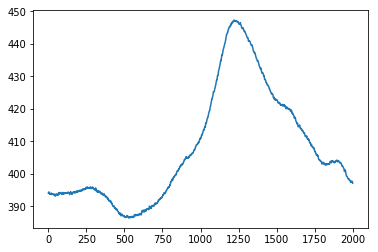

In [92]:
plt.plot(nr_interp_mean)

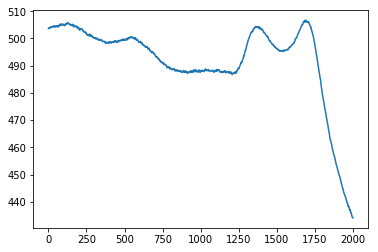

In [428]:
plt.plot(s_interp_mean)

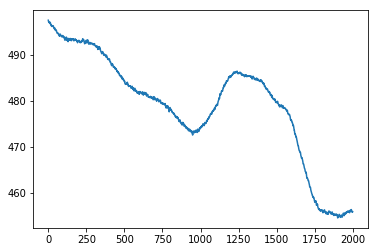

In [429]:
plt.plot((w_interp_mean))

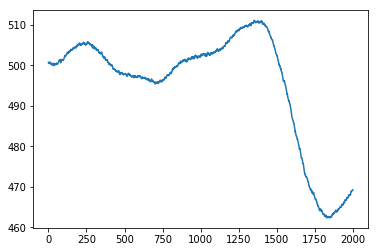

In [430]:
plt.plot(i_interp_mean)

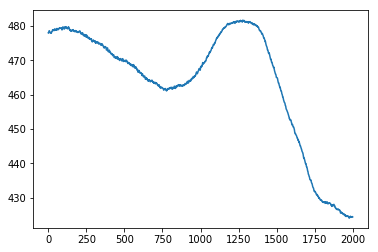

In [431]:
plt.plot(m_interp_mean)

In [301]:
pd.DataFrame(nr_trials_interp.values.T)

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,442.0,398.0,385.0,395.0,391.0,380.0,408.0,359.0,392.0,408.0,...,353.000000,386.0,427.0,313.0,446.0,388.0,329.0,373.0,287.0,372.0
1,442.0,398.0,385.0,395.0,391.0,381.0,408.0,359.0,392.0,408.0,...,354.000000,385.0,428.0,312.0,446.0,388.0,329.0,374.0,293.0,372.0
2,442.0,399.0,386.0,394.0,392.0,381.0,408.0,359.0,391.0,408.0,...,354.000000,384.0,428.0,312.0,446.0,388.0,329.0,374.0,296.0,372.0
3,443.0,399.0,385.0,395.0,393.0,381.0,408.0,358.0,392.0,408.0,...,354.000000,384.0,428.0,311.0,447.0,387.0,329.0,374.0,298.0,373.0
4,443.0,398.0,385.0,395.0,394.0,380.0,407.0,358.0,392.0,408.0,...,354.000000,385.0,427.0,312.0,447.0,387.0,329.0,374.0,297.0,373.0
5,443.0,398.0,384.0,395.0,394.0,380.0,406.0,359.0,392.0,408.0,...,354.000000,385.0,426.0,313.0,447.0,387.0,329.0,374.0,298.0,374.0
6,443.0,398.0,384.0,394.0,394.0,379.0,406.0,359.0,392.0,407.0,...,353.000000,385.0,425.0,314.0,446.0,387.0,329.0,373.0,298.0,374.0
7,442.0,398.0,385.0,394.0,394.0,379.0,406.0,358.0,392.0,407.0,...,354.000000,386.0,425.0,314.0,445.0,388.0,329.0,373.0,299.0,374.0
8,442.0,399.0,385.0,395.0,394.0,379.0,406.0,358.0,392.0,407.0,...,352.000000,386.0,425.0,314.0,445.0,388.0,329.0,373.0,299.0,374.0
9,443.0,400.0,386.0,396.0,394.0,379.0,406.0,358.0,393.0,407.0,...,351.000000,387.0,425.0,313.0,445.0,389.0,329.0,373.0,297.0,374.0


## Plotting comparison

### Pre-buffer

(300, 500)

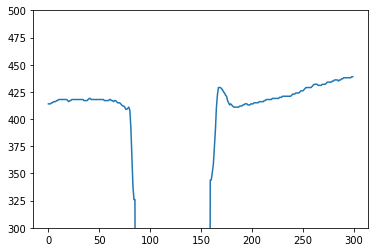

In [73]:
plt.plot(nr_trials[1,1600:1900])
plt.ylim(300,500)

### 10 ms buffer
Seems like it doesn't remove artifact fully

(300, 500)

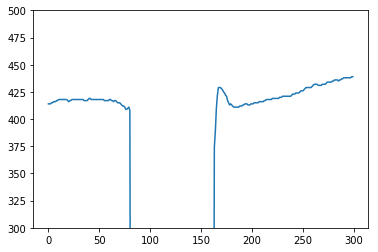

In [74]:
plt.plot(blink_buffer_loop(nr_trials,buffer=5)[1][1600:1900])
plt.ylim(300,500)

### 20 ms buffer
Artifact remains

(300, 500)

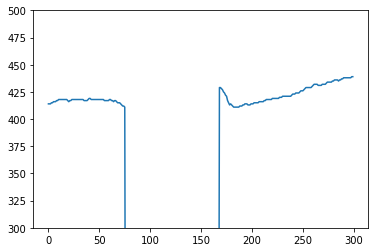

In [75]:
plt.plot(blink_buffer_loop(nr_trials,buffer=10)[1][1600:1900])
plt.ylim(300,500)

### 30 ms buffer
Artifact seems to be disappearing but is still there.

(300, 500)

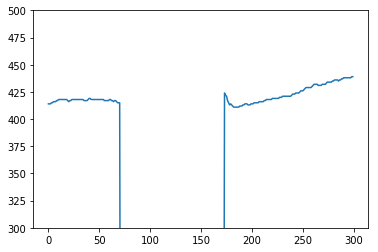

In [76]:
plt.plot(blink_buffer_loop(nr_trials,buffer=15)[1][1600:1900])
plt.ylim(300,500)

### 40 ms buffer
Artifact is mostly gone.

(300, 500)

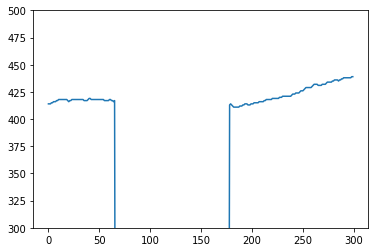

In [77]:
plt.plot(blink_buffer_loop(nr_trials,buffer=20)[1][1600:1900])
plt.ylim(300,500)

### Linear interpolation + 20 ms buffer

(300, 500)

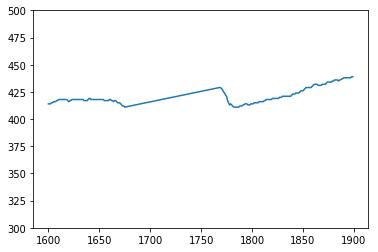

In [102]:
plt.plot(pd.DataFrame(nr_trials_buff).interpolate(method='linear',axis=1,limit_direction='forward').iloc[1,1600:1900])
plt.ylim(300,500)

### Linear interpolation + 40 ms buffer

(300, 500)

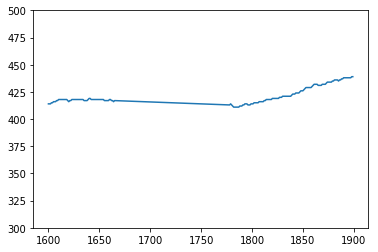

In [83]:
plt.plot(pd.DataFrame(nr_trials_buff).interpolate(method='linear',axis=1,limit_direction='forward').iloc[1,1600:1900])
plt.ylim(300,500)

### Cubic interpolation + 40 ms buffer

(300, 500)

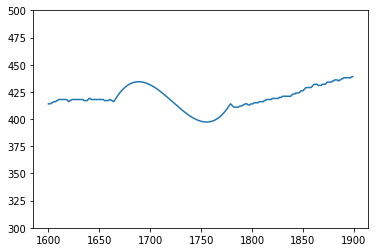

In [84]:
plt.plot(pd.DataFrame(nr_trials_buff).interpolate(method='cubic',axis=1,limit_direction='forward').iloc[1,1600:1900])
plt.ylim(300,500)

### Cubic spline interpolation + 40 ms buffer

(300, 500)

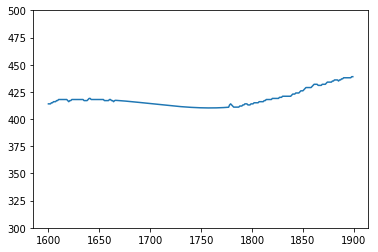

In [85]:
plt.plot(pd.DataFrame(nr_trials_buff).interpolate(method='spline',order=3,axis=1,limit_direction='forward').iloc[1,1600:1900])
plt.ylim(300,500)

### Cubic spline interpolation + 20 ms buffer

(300, 500)

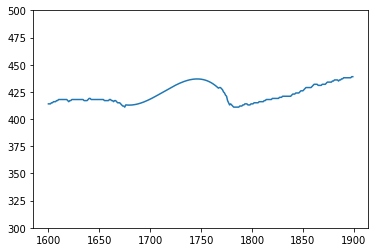

In [87]:
plt.plot(pd.DataFrame(nr_trials_buff).interpolate(method='spline',order=3,axis=1,limit_direction='forward').iloc[1,1600:1900])
plt.ylim(300,500)

(300, 500)

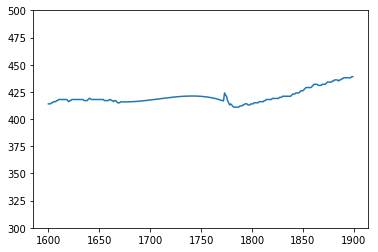

In [104]:
plt.plot(pd.DataFrame(nr_trials_buff).interpolate(method='spline',order=3,axis=1,limit_direction='forward').iloc[1,1600:1900])
plt.ylim(300,500)

In [259]:
# The below function is hard to unpack.
# Innermost we find what indices in some row of nr_trials are equal to zero (i.e. blink) with np.where
# We then use np.diff to take a difference, and then use np.where to check if there are any values not equal to one.
# If it returns any then that means there is more than one blink.
# np.diff having values at index 51, 130 means that our np.where returned indices which differed by more than one at 
# indices 51 and 52 as well as 130 and 131.
# That means index 51 in np.where(nr_trials...) corresponds to the end of a blink and 52 corresponds to the beginning.
# So nr_trials[np.where...[51]] should be zeroed out, as should nr_trials[np.where]

# So what we want to do is find all indices in np.diff(...) which don't equal zero.
# Then for each index we want to find the corresponding index of np.where(nr_trials) and zero out nr_trials around THAT index.
# And also around that index + 1.

# This returns the indices of np.diff which are not equal to one.
# I.E. if this returns the index 4, that means the np.where returned
# two values at its own index four and five which differ by more than 1.
# This corresponds to 
np.where(np.diff(np.where(nr_trials[16]==0)[0])!=1)[0]

array([ 51, 130], dtype=int64)

In [263]:
np.where(np.diff(np.where(nr_trials[16]==0)[0])!=1)[0]

array([ 51, 130], dtype=int64)

In [256]:
for i in np.where(np.diff(np.where(nr_trials[16]==0)[0])!=1)[0]:
    print(np.where(nr_trials[16]==0)[0][i])

In [320]:
np.where(nr_trials[1]==0)

(array([1186, 1187, 1188, 1189, 1190, 1191, 1192, 1193, 1194, 1195, 1196,
        1197, 1198, 1199, 1200, 1201, 1202, 1203, 1204, 1205, 1206, 1207,
        1208, 1209, 1210, 1211, 1212, 1213, 1214, 1215, 1216, 1217, 1218,
        1219, 1220, 1221, 1222, 1223, 1224, 1225, 1226, 1227, 1228, 1229,
        1230, 1231, 1232, 1233, 1234, 1235, 1236, 1237, 1238, 1239, 1240,
        1241, 1242, 1243, 1244, 1245, 1246, 1247, 1248, 1249, 1250, 1251,
        1252, 1253, 1254, 1255, 1256, 1257, 1258], dtype=int64),)

In [309]:
def blink_buffer(array,buffer_=15):
    arr_ = np.copy(array)
    for i in range(arr_.shape[0]):
        # Need a way to distinguish between trials which have only one blink and those which have multiple.
        # In either case we can easily grab and zero out the beginning of the first blink and the end of the last.

        # Grab beginning and end of single blink, then get indices length of buffer up and down from center
        blink_times_ = np.where(arr_[i]==0)[0]

        center1_ = blink_times_[0]
        center2_ = blink_times_[-1]

        arr_[i,center1_-buffer_:center1_+buffer_+1]=0
        arr_[i,center2_-buffer_:center2_+buffer_+1]=0

        # The below condition will be satisfied when not all the indices returned by np.where are one.
        # This is implemented by using np.diff to get the differences between consecutive values in blink_times_, then subtracting one.
        # If all the values in blink_times_ are consecutive (one blink in the trial) then this makes all of the inside zero i.e. false.
        # If at least one jump in blink_times_ is not consecutive (i.e. 2+ blinks in trial) then one value will be nonzero i.e. true.
        if (np.diff(blink_times_)-1).any():

            # Find indices where np.diff doesn't return a one. Then the returned index and the returned index+1 will correspond to
            # beginnings or ends of blinks.
            non_consec_ = np.where(np.diff(blink_times_)[0]!=1)[0]
            for blink_idx_ in non_consec_:
                center1_ = blink_times_[blink_idx]
                center2_ = blink_times_[blink_idx+1]

                arr_[i,center1_-buffer_:center1_+buffer_+1]=0
                arr_[i,center2_-buffer_:center2_+buffer_+1]=0

    return arr_


In [271]:
if (np.diff(np.where(nr_trials[16]==0)[0])-1).any():
    print(1)

1


In [274]:
(np.diff(np.where(nr_trials[16]==0)[0])-1).any()

True

In [324]:
nr_trials[nr_trials==0]=1

(30, 2000)

In [125]:
# What is the best way to take in a data format for blink interpolation? Probably 



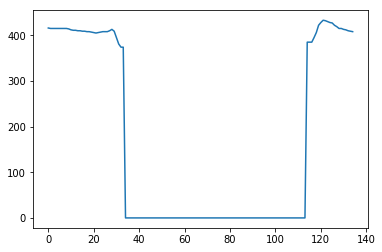

In [327]:
plt.plot(nr_trials[5][1150:1285])

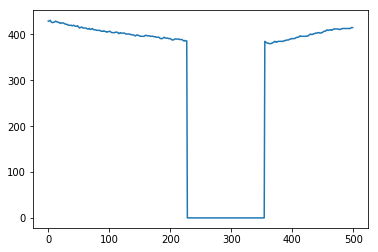

In [339]:
plt.plot(blink_buffer_loop(nr_trials,buffer=20)[16][1500:2000])

(300, 500)

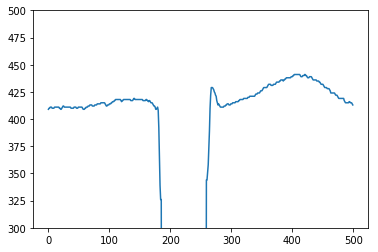

In [54]:
plt.plot(nr_trials[1,1500:2000])
plt.ylim(300,500)

(300, 500)

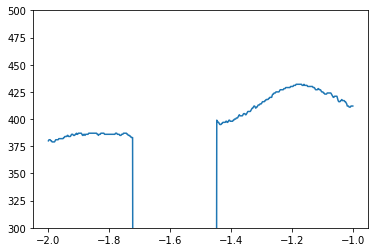

In [96]:
idx = 5
buffer=20
# print(nr_trials.iloc[i,-1].shape)
XX=np.array([i for i in range(0,500)])*0.002-2
plt.plot(XX,blink_buffer_loop(nr_trials,buffer)[idx,0:500])
plt.ylim(300,500)

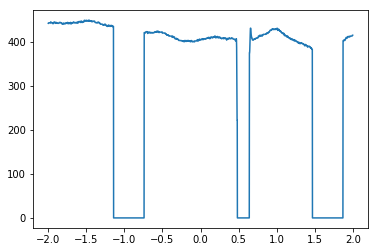

In [331]:
idx = 16
# print(nr_trials.iloc[i,-1].shape)
XX=np.array([i for i in range(0,2000)])*0.002-2
plt.plot(XX,blink_buffer(nr_trials,100)[idx])

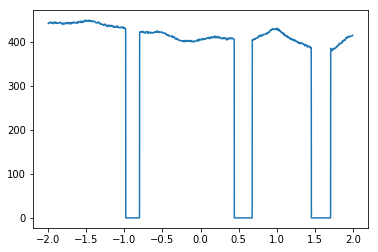

In [335]:
idx = 16
# print(nr_trials.iloc[i,-1].shape)
XX=np.array([i for i in range(0,2000)])*0.002-2
plt.plot(XX,blink_buffer_loop(nr_trials,20)[idx])

In [314]:
# print(w_trials['PupilSize'][0,:].values.shape)
print(np.mean(w_trials['PupilSize'].values,axis=0).shape)

KeyError: 'PupilSize'

In [55]:
# NO BLINK REMOVAL
nr_mean = np.mean(nr_trials['PupilSize'].values,axis=0)
w_mean = np.mean(w_trials['PupilSize'].values,axis=0)
m_mean = np.mean(m_trials['PupilSize'].values,axis=0)
s_mean = np.mean(s_trials['PupilSize'].values,axis=0)
i_mean = np.mean(i_trials['PupilSize'].values,axis=0)

KeyError: 'PupilSize'

In [ ]:
XX=np.array([i for i in range(0,2000)])*0.002-2
plt.plot(XX,nr_mean)

In [ ]:
XX=np.array([i for i in range(0,2000)])*0.002-2
plt.plot(XX,w_mean)

In [ ]:
XX=np.array([i for i in range(0,2000)])*0.002-2
plt.plot(XX,m_mean)

In [ ]:
XX=np.array([i for i in range(0,2000)])*0.002-2
plt.plot(XX,s_mean)

In [ ]:
XX=np.array([i for i in range(0,2000)])*0.002-2
plt.plot(XX,i_mean)

In [ ]:
XX=np.array([i for i in range(0,2000)])*0.002-2
plt.plot(XX,w_mean-nr_mean)

In [ ]:
nr_trials[(nr_trials.T !=0).all()]